USING THIS AS A REFERENCE

https://www.geeksforgeeks.org/deep-learning/building-a-vision-transformer-from-scratch-in-pytorch

Dataset used:
https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification/data

Satellite image Classification Dataset-RSI-CB256 , This dataset has 4 different classes mixed from Sensors and google map snapshot
Labels and quantities:
Cloudy 1500
Desert 1131
Green_Area 1500
Water 1500

In [19]:
import platform
import psutil
import torch
import sys

# Import other key packages safely
try:
    import timm
except ImportError:
    timm = None

try:
    import safetensors
except ImportError:
    safetensors = None

try:
    import sklearn
except ImportError:
    sklearn = None

try:
    import numpy
except ImportError:
    numpy = None


def get_windows_version():
    if platform.system() == "Windows":
        build = sys.getwindowsversion().build
        if build >= 22000:
            return "Windows 11"
        else:
            return "Windows 10 or earlier"
    else:
        return platform.system()


def get_detailed_cpu_info():
    info = {}

    # CPU brand and architecture
    info['Processor'] = platform.processor()
    info['Machine'] = platform.machine()

    # Physical cores
    info['Physical cores'] = psutil.cpu_count(logical=False)

    # Logical processors (threads)
    info['Logical processors'] = psutil.cpu_count(logical=True)

    # CPU frequency info per core
    freq = psutil.cpu_freq(percpu=True)
    if freq:
        info['CPU frequency per core (MHz)'] = [f.current for f in freq]
    else:
        info['CPU frequency per core (MHz)'] = None

    # Average CPU frequency
    avg_freq = psutil.cpu_freq()
    info['Average CPU frequency (MHz)'] = avg_freq.current if avg_freq else None

    return info


def get_system_info():
    info = get_detailed_cpu_info()

    # RAM information (GB)
    mem = psutil.virtual_memory()
    info['RAM_GB'] = round(mem.total / (1024 ** 3), 2)

    # Operating System details with accurate Windows version detection
    info['OS_System'] = platform.system()
    info['OS_Version'] = get_windows_version() if info['OS_System'] == "Windows" else platform.version()
    info['OS_Node'] = platform.node()
    info['OS_Release'] = platform.release()
    info['OS_Machine'] = platform.machine()
    info['OS_Processor'] = platform.processor()

    # Python version
    info['Python_Version'] = platform.python_version()

    # Package versions where available
    info['PyTorch_Version'] = torch.__version__
    info['Timm_Version'] = timm.__version__ if timm else "Not installed"
    info['Safetensors_Version'] = safetensors.__version__ if safetensors else "Not installed"
    info['Scikit-learn_Version'] = sklearn.__version__ if sklearn else "Not installed"
    info['NumPy_Version'] = numpy.__version__ if numpy else "Not installed"

    # CUDA info
    info['CUDA_Available'] = torch.cuda.is_available()
    info['CUDA_Version'] = torch.version.cuda if torch.cuda.is_available() else None
    info['GPU_Name'] = torch.cuda.get_device_name(0) if torch.cuda.is_available() else None

    return info


if __name__ == "__main__":
    system_info = get_system_info()
    for k, v in system_info.items():
        print(f"{k}: {v}")


Processor: AMD64 Family 25 Model 117 Stepping 2, AuthenticAMD
Machine: AMD64
Physical cores: 8
Logical processors: 16
CPU frequency per core (MHz): [2516.0]
Average CPU frequency (MHz): 2516.0
RAM_GB: 15.31
OS_System: Windows
OS_Version: Windows 11
OS_Node: Nitro-V16-4060
OS_Release: 10
OS_Machine: AMD64
OS_Processor: AMD64 Family 25 Model 117 Stepping 2, AuthenticAMD
Python_Version: 3.10.0
PyTorch_Version: 2.8.0+cu126
Timm_Version: 1.0.22
Safetensors_Version: 0.7.0
Scikit-learn_Version: 1.7.2
NumPy_Version: 1.26.4
CUDA_Available: True
CUDA_Version: 12.6
GPU_Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [20]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # Batch size, Channels, Height, Width of the input tensor
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [21]:
# 2. Adding Positional Embeddings
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, seq_len):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.randn(1, seq_len + 1, embed_dim))  # Adjusted for [CLS] token

    def forward(self, x):
        return x + self.pos_embed

In [22]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, x):
        # x: (B, S, E) where
        # B = batch size,
        # S = sequence length (number of patches or tokens),
        # E = embedding dimension (feature size per token)
        out, _ = self.attn(x, x, x)
        return out


In [23]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super().__init__()
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):

        # Apply LayerNorm then Multi-Head Self-Attention to capture contextual relationships across tokens
        x = x + self.attn(self.norm1(x))
        # Residual connection adds input back after attention

        # Apply LayerNorm then position-wise Feed-Forward Network (MLP) for non-linear token-wise transformation
        x = x + self.mlp(self.norm2(x))
        # Residual connection again
        
        return x

In [24]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, num_classes=10, embed_dim=768, num_heads=8, depth=6, mlp_dim=1024):
        super().__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, 3, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim, (img_size // patch_size) ** 2)
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim) for _ in range(depth)
        ])
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.mlp_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embedding(x)  # shape: (B, num_patches, embed_dim)
        
        ##### Added by Archit
        if x.size(1) != self.pos_encoding.pos_embed.size(1): pos_embed = self.pos_encoding.pos_embed[:, :x.size(1), :]

        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, num_patches + 1, embed_dim)

        # Adjust positional encoding to input sequence length
        if x.size(1) != self.pos_encoding.pos_embed.size(1):
            pos_embed = self.pos_encoding.pos_embed[:, :x.size(1), :]
        else:
            pos_embed = self.pos_encoding.pos_embed

        x = x + pos_embed

        for block in self.transformer_blocks:
            x = block(x)

        return self.mlp_head(x[:, 0])


In [25]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset


# Parameters
path = "satellite_data/"
batch_size = 32
height = 224
width = 224
val_split_ratio = 0.2


# Augmentation transforms for training
train_transform = transforms.Compose([
    transforms.Resize((height, width)),           # Resize to your specified size
    #transforms.RandomHorizontalFlip(p=0.5),       # Random horizontal flip
    #transforms.RandomVerticalFlip(p=0.5),         # Random vertical flip
    #transforms.RandomRotation(degrees=30),        # Random rotation within ±30 degrees (turned off because resolution too low)
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


# Validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


# Load the full dataset without transforms first
full_dataset = datasets.ImageFolder(root=path)


# Calculate split lengths
val_size = int(len(full_dataset) * val_split_ratio)
train_size = len(full_dataset) - val_size


# Indices for train and validation splits
train_indices = list(range(train_size))
val_indices = list(range(train_size, train_size + val_size))


# Create subsets for train and validation
train_subset = Subset(full_dataset, train_indices)
val_subset = Subset(full_dataset, val_indices)


# Dataset class to apply transform dynamically
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.dataset)


# Wrapped datasets with appropriate transforms
train_dataset = AugmentedDataset(train_subset, train_transform)
val_dataset = AugmentedDataset(val_subset, val_transform)


# DataLoaders - WINDOWS SAFE (num_workers=0 prevents 95% of hangs)
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0,           # ← FIXED: 0 prevents multiprocessing deadlock
    pin_memory=False,        # ← FIXED: False prevents GPU pinning issues
    persistent_workers=False # ← FIXED: False prevents worker hang
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,           # ← CORRECT: False for validation
    num_workers=0,           # ← FIXED: 0 prevents validation hangs
    pin_memory=False,        # ← FIXED: False for stability
    drop_last=False,         # ← ADDED: Keep last incomplete batch
    persistent_workers=False
)

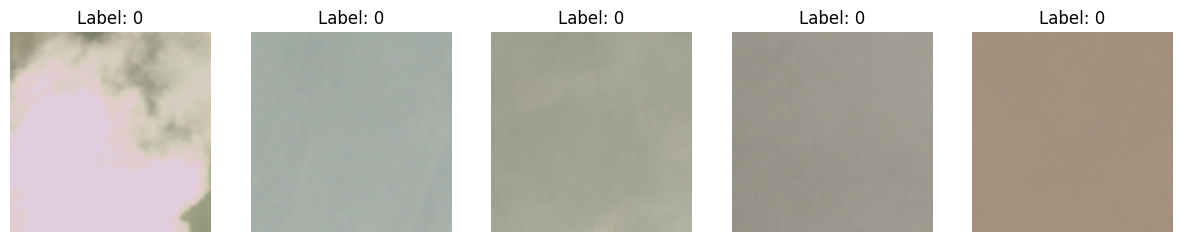

In [26]:
# Make sure augmentation is working properly by showing random images from augmented dataset

import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show_augmented_images(dataset, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        img, label = dataset[i]
        # Convert tensor to numpy image with proper normalization reversal for display
        img_show = img.permute(1, 2, 0).numpy()
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        img_show = std * img_show + mean
        img_show = img_show.clip(0, 1)
        axes[i].imshow(img_show)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

show_augmented_images(train_dataset, n=5)


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [28]:
##### HYBRID VERSION, using many parts of the final pretrained model so that they can be both tested in the same conditions
# make sure this one is using 224x244 images to test 1:1 with the pretrained, check transforms in the above cells

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
import timm
import numpy as np


##### Parameters:
##### original: lr 0.001 / epoch 5 / batch_size 32
lr = 1e-3  # ← INCREASED: From 3e-4 (too low for from-scratch)
epoch_count = 20
batch_size = 16
weight_decay = 0.05


print(f"Dataset size: {len(train_dataset)} images")


# OPTIMIZED DATALOADER
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
    persistent_workers=False
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Load model
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 4)  # ← FIXED: num_classes=4
model.to(device)


# ← NEW: Class weights for imbalance (Desert has fewer samples)
train_labels = [y for _, y in train_dataset]
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
class_weights = torch.FloatTensor(class_weights).to(device)
print("Class weights:", class_weights.cpu().numpy())


# Performance optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


criterion = nn.CrossEntropyLoss(weight=class_weights)  # ← FIXED: Weighted loss
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scaler = GradScaler('cuda')


# Start total timer
total_start_time = time.time()


# To be used later for graphs
class TrainingHistory:
    def __init__(self):
        # Initialize with epoch 0 values all set to zero
        self.losses = [0.0]
        self.accuracies = [0.0]
        self.precisions = [0.0]
        self.recalls = [0.0]
        self.f1s = [0.0]
        self.durations = [0.0]


# Create history object before training
history = TrainingHistory()


# ensure consistency in epoch count, use the same digits count so that i have formatted outputs
# i didn't bother running it with 100 epoch count, but it does work with 1 to 20 epochs
width = len(str(epoch_count))


print(f"Epoch [{0:0{width}d}/{epoch_count}] "
      f"Loss: {0.0:.4f} Accuracy: {0.0:.4f} Precision: {0.0:.4f} "
      f"Recall: {0.0:.4f} F1-score: {0.0:.4f} "
      f"Epoch Time: {0.00:.2f} seconds")


# MAIN TRAINING LOOP
for epoch in range(epoch_count):  # Train for epoch_count epochs
    epoch_start_time = time.time()  # Start timer for this epoch

    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    epoch_end_time = time.time()  # End timer for this epoch
    epoch_duration = epoch_end_time - epoch_start_time

    # Store metrics and duration in history object
    history.losses.append(epoch_loss)
    history.accuracies.append(accuracy)
    history.precisions.append(precision)
    history.recalls.append(recall)
    history.f1s.append(f1)
    history.durations.append(epoch_duration)

    print(f"Epoch [{epoch+1:0{width}d}/{epoch_count}] "
          f"Loss: {epoch_loss:.4f} Accuracy: {accuracy:.4f} Precision: {precision:.4f} "
          f"Recall: {recall:.4f} F1-score: {f1:.4f} "
          f"Epoch Time: {epoch_duration:.2f} seconds")

# End total timer
total_end_time = time.time()
total_duration = total_end_time - total_start_time

print(f"Total Training Time: {total_duration:.2f} seconds")


Dataset size: 4505 images
Using device: cuda
Class weights: [0.00066667 0.00088417 0.00066667 0.0026738 ]
Epoch [00/20] Loss: 0.0000 Accuracy: 0.0000 Precision: 0.0000 Recall: 0.0000 F1-score: 0.0000 Epoch Time: 0.00 seconds
Epoch [01/20] Loss: 0.8839 Accuracy: 0.7088 Precision: 0.7638 Recall: 0.7088 F1-score: 0.7278 Epoch Time: 54.25 seconds
Epoch [02/20] Loss: 0.7238 Accuracy: 0.7170 Precision: 0.7780 Recall: 0.7170 F1-score: 0.7378 Epoch Time: 54.90 seconds
Epoch [03/20] Loss: 0.5656 Accuracy: 0.7627 Precision: 0.8152 Recall: 0.7627 F1-score: 0.7812 Epoch Time: 55.34 seconds
Epoch [04/20] Loss: 0.5018 Accuracy: 0.7865 Precision: 0.8335 Recall: 0.7865 F1-score: 0.8029 Epoch Time: 55.09 seconds
Epoch [05/20] Loss: 0.4799 Accuracy: 0.8038 Precision: 0.8435 Recall: 0.8038 F1-score: 0.8183 Epoch Time: 55.14 seconds
Epoch [06/20] Loss: 0.4866 Accuracy: 0.8171 Precision: 0.8401 Recall: 0.8171 F1-score: 0.8261 Epoch Time: 55.16 seconds
Epoch [07/20] Loss: 0.4862 Accuracy: 0.8007 Precision: 

To better understand the metrics used:

Loss: Measures the model's error in prediction by quantifying how far the predictions are from the true labels using the loss function (in this case cross-entropy). Lower loss indicates better fit to training data. Loss is crucial during training as it is the value optimized by the model's algorithm to improve performance
(The lower the better)

Accuracy: Represents the proportion of correct predictions out of all predictions made. It's a simple and intuitive measure of overall correctness but can be misleading when classes training data is imbalanced in the ratio (in this dataset it's fairly even, except for desert which has roughly 80% of the data count)
Cloudy 1500 / Desert 1131 / Green_Area 1500 / Water 1500

Precision: Indicates how many predicted positive cases were actually positive. This metric is especially important when false positives are costly, such as in medical diagnoses or fraud detection, ensuring that positive predictions are reliable

Recall: Measures how many actual positive cases were correctly identified. It's critical in scenarios where missing positive cases has a high cost (false negatives), like disease screening, emphasizing sensitivity

F1-score: The harmonic mean of precision and recall, providing a balanced metric especially valuable when you need to account for both false positives and false negatives, and when class distribution is uneven. It summarizes model performance in one number

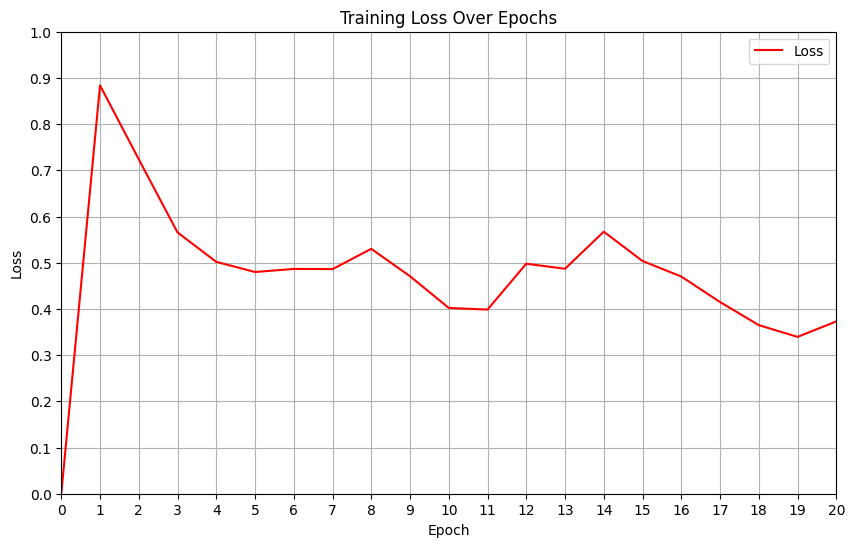

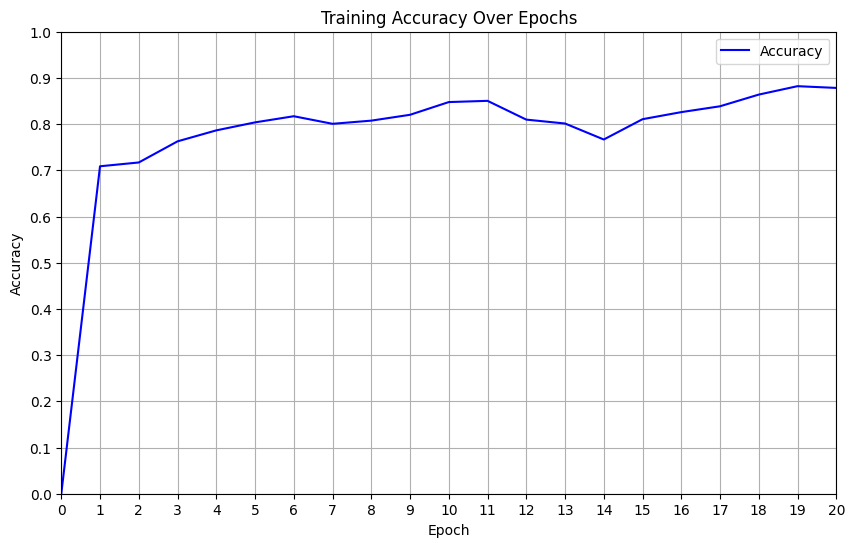

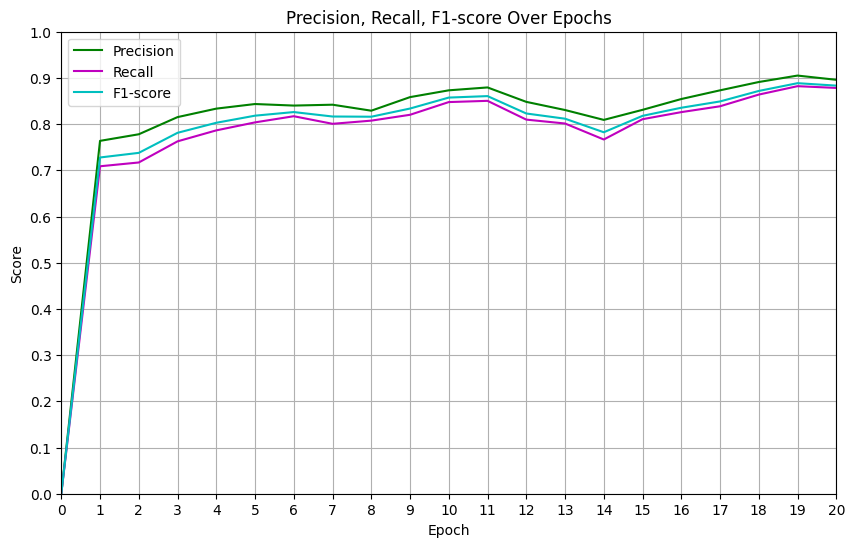

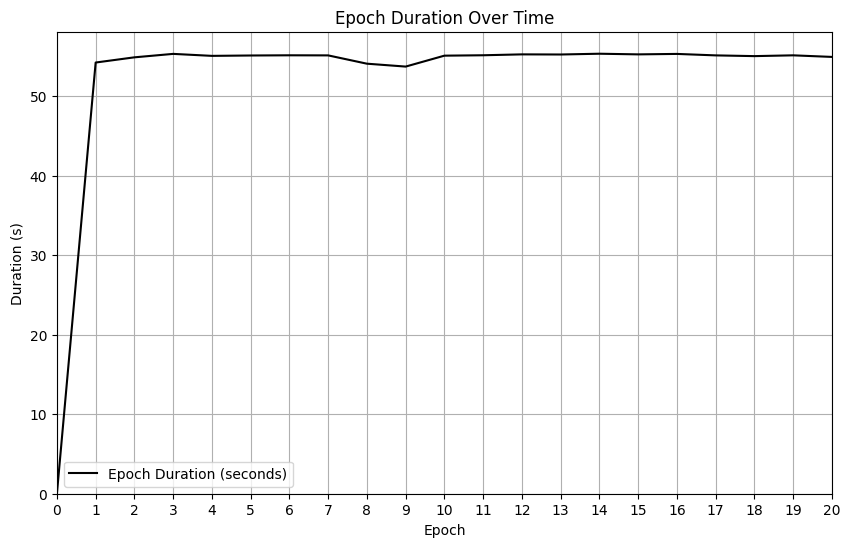

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# use history (from the earlier model's training results) to compute graphs
epochs = range(0, len(history.losses))



# Plot Loss (Loss may not cap at 1.0 but for consistency, set max to 1.0)
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.losses, 'r-', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))  
plt.xlim(0, epoch_count)
plt.ylim(0, 1.0)  # y-axis max 1.0
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.accuracies, 'b-', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.xlim(0, epoch_count)
plt.ylim(0, 1.0)
plt.show()

# Plot Precision, Recall, and F1-score together
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.precisions, 'g-', label='Precision')
plt.plot(epochs, history.recalls, 'm-', label='Recall')
plt.plot(epochs, history.f1s, 'c-', label='F1-score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Precision, Recall, F1-score Over Epochs')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.xlim(0, epoch_count)
plt.ylim(0, 1.0)
plt.show()


# Plot Epoch Duration
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.durations, 'k-', label='Epoch Duration (seconds)')
plt.xlabel('Epoch')
plt.ylabel('Duration (s)')
plt.title('Epoch Duration Over Time')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # set tick interval to 1
plt.xlim(0, epoch_count)
plt.ylim(bottom=0) # start y-axis at 0
plt.show()


In [30]:
from sklearn.metrics import confusion_matrix
import numpy as np

# After the epoch evaluation (after collecting all_preds and all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:")
print(cm)


epoch_loss = running_loss / len(train_loader)
accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

# New code for confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

print(f"Epoch [{epoch+1}/{epoch+1}] Loss: {epoch_loss:.4f} Accuracy: {accuracy:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1-score: {f1:.4f}")


Confusion Matrix:
[[1299  153   15   33]
 [  40 1088    0    3]
 [   0    0 1281  219]
 [  13    0   72  289]]
Confusion Matrix:
[[1299  153   15   33]
 [  40 1088    0    3]
 [   0    0 1281  219]
 [  13    0   72  289]]
Epoch [20/20] Loss: 0.3729 Accuracy: 0.8784 Precision: 0.8959 Recall: 0.8784 F1-score: 0.8833


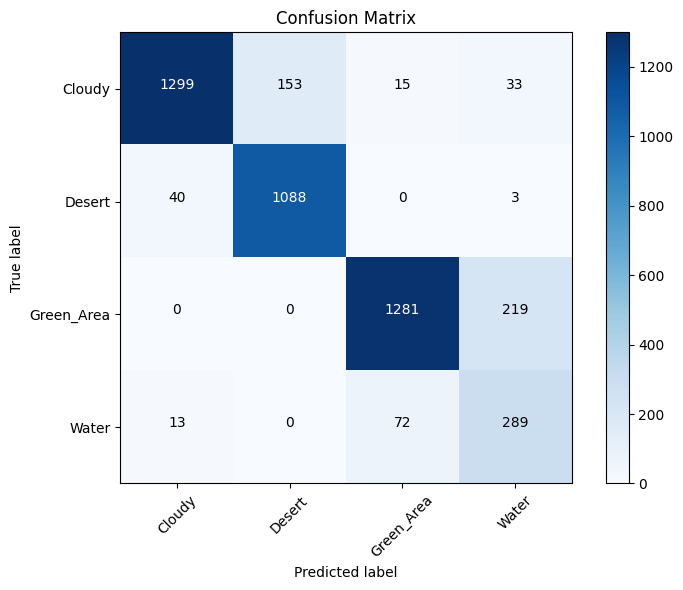

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming 'all_labels' and 'all_preds' contain true and predicted labels respectively
labels_names = ['Cloudy', 'Desert', 'Green_Area', 'Water']

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Labeling the axes with class names
num_classes = cm.shape[0]
plt.xticks(np.arange(num_classes), labels=labels_names, rotation=45)
plt.yticks(np.arange(num_classes), labels=labels_names)

# Axis labels
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Adding counts on the plot
thresh = cm.max() / 2
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


From this confusion matrix we can confidently say there's a bit of error when predicting labels 2 and 3 (Green_Area and Water), labels 0 and 1 show a similar problem (Cloudy and Desert), but not in a very accentuated way

In [32]:
##### for testing purposes only

from PIL import Image
from collections import defaultdict
import os

# full_dataset is ImageFolder with transform=transform (might convert images, so ignore it here)

# Map from class index to class name
class_names = full_dataset.classes

# Store counts of resolutions per class
resolutions_per_class = {cls: defaultdict(int) for cls in class_names}

# Iterate over dataset samples (image paths are in dataset.imgs or dataset.samples)
for img_path, label in full_dataset.samples:
    with Image.open(img_path) as img:
        # Get image size (width, height)
        size = img.size
    class_name = class_names[label]
    # Increment count for this resolution for this class
    resolutions_per_class[class_name][size] += 1

# Print summary for each class
for cls, res_counts in resolutions_per_class.items():
    print(f"Class '{cls}':")
    for res, count in sorted(res_counts.items()):
        print(f"  Resolution {res[0]}x{res[1]} : {count} images")
    print()


Class 'cloudy':
  Resolution 256x256 : 1500 images

Class 'desert':
  Resolution 256x256 : 1131 images

Class 'green_area':
  Resolution 64x64 : 1500 images

Class 'water':
  Resolution 64x64 : 1500 images



Results in locally trained baseline (before data augmentation):

From the results from being run on a 4060 Mobile GPU we can confidently say that the model shows marginal changes after the 10th epoch, but usually goes from 90 to 92.5% accuracy at around 13th epoch, it might actually be counterproductive to run the model for longer since it seems to degenerate into slightly worse performance

Results in locally trained with data augmentation:

Precision down from 90/92% to 88%, loss is consistently the same throughout the whole train sequence (0.35 average on augmented, while goes down to 0.2 in baseline), this is suggesting that something is wrong with augmentation, will require further testing
Tried disabling roation (having a 64x64 images there isn't much to rotate at all) and it had no effect, but maybe testing for longer (50 epochs would? we are training at twice the speed, it's only fair to run the model for twice as long to give it the same time to shine)
Apparently not, doesn't even touch the 90% accuracy, and something odd happened at epoch 37, train time jumped from 20 to 28.8s for no reason
Epoch [37/50] Loss: 0.3286 Accuracy: 0.8744 Precision: 0.8667 Recall: 0.8744 F1-score: 0.8648 Epoch Time: 28.82 seconds
Dataloades have workers set at 4

Labels and quantities:
Cloudy 1500
Desert 1131
Green_Area 1500
Water 1500

Confirmed through dataset looping:

Class 'cloudy':  Resolution 256x256 : 1500 images
Class 'desert':  Resolution 256x256 : 1131 images
Class 'green_area':  Resolution 64x64 : 1500 images
Class 'water':  Resolution 64x64 : 1500 images

A Visual Transformer tends to be data hungry, so perhaps there's an inherent flaw in attempting this with a small dataset with small images

In [33]:
# VALIDATION EVALUATION (after training completes) - ENHANCED
print("FINAL VALIDATION RESULTS")

model.eval()
val_running_loss = 0.0
val_all_preds = []
val_all_labels = []
batch_count = 0

print(f"Validation batches: {len(val_loader)}")

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(val_loader):
        batch_count += 1
        if batch_idx % 10 == 0:
            print(f"  Batch {batch_idx}/{len(val_loader)}")
            
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_running_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        val_all_preds.extend(preds.cpu().numpy())
        val_all_labels.extend(labels.cpu().numpy())

# Same metrics format (unchanged)
from sklearn.metrics import precision_score, recall_score, f1_score
val_loss = val_running_loss / len(val_loader)
val_accuracy = (torch.tensor(val_all_preds) == torch.tensor(val_all_labels)).float().mean().item()
val_precision = precision_score(val_all_labels, val_all_preds, average='weighted', zero_division=0)
val_recall = recall_score(val_all_labels, val_all_preds, average='weighted', zero_division=0)
val_f1 = f1_score(val_all_labels, val_all_preds, average='weighted', zero_division=0)

print(f"Loss: {val_loss:.4f} Accuracy: {val_accuracy:.4f} Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f} F1-score: {val_f1:.4f}")
print(f"Validation samples: {len(val_all_labels)}")

FINAL VALIDATION RESULTS
Validation batches: 36
  Batch 0/36
  Batch 10/36
  Batch 20/36
  Batch 30/36
Loss: 0.4907 Accuracy: 0.9005 Precision: 1.0000
Recall: 0.9005 F1-score: 0.9477
Validation samples: 1126


Unique true labels: [3]
Unique predictions: [0 1 2 3]
Prediction counts: [  20    4   88 1014]
Label counts: [   0    0    0 1126]
FINAL VALIDATION RESULTS
Loss: 0.4907 Accuracy: 0.9005 Precision: 1.0000
Recall: 0.9005 F1-score: 0.9477
Validation samples: 1126
Classes detected: ['cloudy', 'desert', 'green_area', 'water']
Confusion matrix shape: (4, 4)


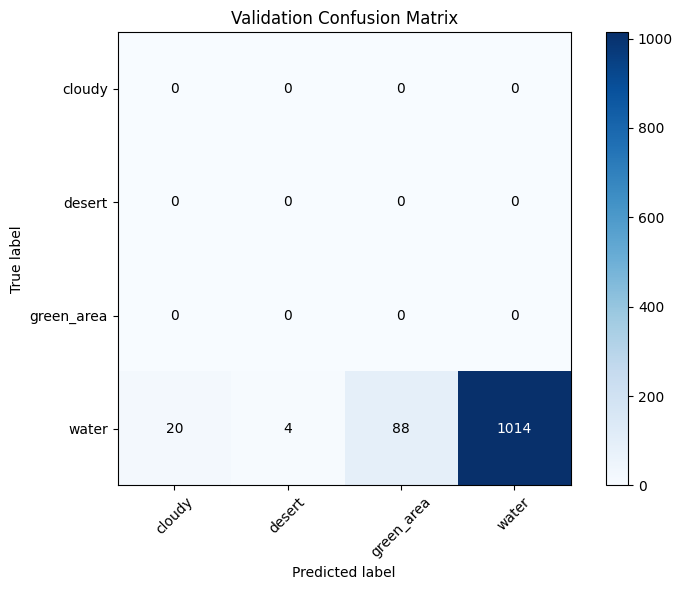

In [34]:
# DEBUG: Check what's actually happening
print("Unique true labels:", np.unique(val_all_labels))
print("Unique predictions:", np.unique(val_all_preds))
print("Prediction counts:", np.bincount(val_all_preds))
print("Label counts:", np.bincount(val_all_labels))




# VALIDATION EVALUATION (after training completes)
print("FINAL VALIDATION RESULTS")

model.eval()
val_running_loss = 0.0
val_all_preds = []
val_all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_running_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        val_all_preds.extend(preds.cpu().numpy())
        val_all_labels.extend(labels.cpu().numpy())

# Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
val_loss = val_running_loss / len(val_loader)
val_accuracy = (torch.tensor(val_all_preds) == torch.tensor(val_all_labels)).float().mean().item()
val_precision = precision_score(val_all_labels, val_all_preds, average='weighted', zero_division=0)
val_recall = recall_score(val_all_labels, val_all_preds, average='weighted', zero_division=0)
val_f1 = f1_score(val_all_labels, val_all_preds, average='weighted', zero_division=0)

print(f"Loss: {val_loss:.4f} Accuracy: {val_accuracy:.4f} Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f} F1-score: {val_f1:.4f}")
print(f"Validation samples: {len(val_all_labels)}")
print("="*80)

# FIXED CONFUSION MATRIX PLOT
labels_names = full_dataset.classes
print(f"Classes detected: {labels_names}")

cm = confusion_matrix(val_all_labels, val_all_preds)
print(f"Confusion matrix shape: {cm.shape}")

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Validation Confusion Matrix')
plt.colorbar()

num_classes = cm.shape[0]
plt.xticks(np.arange(num_classes), labels_names[:num_classes], rotation=45)
plt.yticks(np.arange(num_classes), labels_names[:num_classes])

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


In [35]:
print("=== FULL DATASET CHECK ===")
print(f"Total samples: {len(full_dataset)}")
print(f"Classes: {full_dataset.classes}")

print("Class counts:")
for i, cls in enumerate(full_dataset.classes):
    count = sum(1 for _, label in full_dataset.samples if label == i)
    print(f"  {cls}: {count}")

print("\n=== SPLIT INDICES CHECK ===")
print(f"Train size: {len(train_indices)}, Val size: {len(val_indices)}")

train_labels = [full_dataset.samples[i][1] for i in train_indices]
val_labels = [full_dataset.samples[i][1] for i in val_indices]

print("Train unique labels:", sorted(set(train_labels)))
print("Train counts:", np.bincount(train_labels))
print("Val unique labels: ", sorted(set(val_labels)))
print("Val counts:     ", np.bincount(val_labels))


=== FULL DATASET CHECK ===
Total samples: 5631
Classes: ['cloudy', 'desert', 'green_area', 'water']
Class counts:
  cloudy: 1500
  desert: 1131
  green_area: 1500
  water: 1500

=== SPLIT INDICES CHECK ===
Train size: 4505, Val size: 1126
Train unique labels: [0, 1, 2, 3]
Train counts: [1500 1131 1500  374]
Val unique labels:  [3]
Val counts:      [   0    0    0 1126]
